#  🤖 Static Agentic RAG with CodeGen

Users can at times expect an AI application to understand their queries, even if they are vague and contain embedded semantic logic, such as a short form query that is actually compound in nature.  There is no explicit breakdown of all subqueries, because domain experts generally understand what is meant by the short form query.  In production, this is a challenging task for an AI model to handle, as foundation models are generally trained on internet scale information, which is not gauranteed to contain domain specific logic.  In fact, this kind of logic could even be harmful for generalization, as the langugage would not make much sense with respect to other contexts.  

Queries, even if clear, may be compound in nature and may require subquery decomposition for targeted QA using paradigms/techniques such as RAG.  This in turn may also necessitate the need for: reranking, vectorstore filtering for initial entity-aware document retrieval to remove/prevent noise, aggregation, etc.

Furthermore, compound queries may be comparitive in nature and may require mathematical operations, which may require the use of a code generation model to generate the code for the mathematical operations.  Alternatively, agents with tools/libraries that can handle such operations can be used, which will add more determinism, and hopefully reliability.  

Note that the longer and more complex the agentic pipeline, the more the possibilities for cumulative errors to come up, and so development and maintenance may become difficult to scale across edge cases.  If this is the case, it may be preferable to move to a dynamic, human in the loop type of system. That route has its own unique challenges, such as robust routing and team setups.  A simple example can be found here: [Corrective RAG team](./../../agent_workflows/notebooks/corrective_rag_team.ipynb).

In [1]:
import os
import sys
from langchain_community.vectorstores import Chroma
from IPython.display import display, Markdown

current_dir = os.getcwd()
kit_dir = os.path.abspath(os.path.join(current_dir, ".."))
repo_dir = os.path.abspath(os.path.join(kit_dir, ".."))

sys.path.append(kit_dir)
sys.path.append(repo_dir)

from enterprise_knowledge_retriever.src.document_retrieval import DocumentRetrieval
from utils.agents.static_RAG_with_coding import CodeRAG

examples = []

CONFIG_PATH = os.path.join(kit_dir, "config.yaml")

/Users/codym/CAP/08_06_2024_aisk/ai-starter-kit/.agent_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the embedding model for semantic search

We will use our DocumentRetrieval class to load the embedding model and vectorstore.  We import this from the enterprise knowledge retrieval package for reuse.  Depending on your needs, you can choose between "sambastudio" or "cpu" for embeddings acceleration.  At present, only the E5 large v2 model is supported.

In [2]:
documentRetrieval = DocumentRetrieval()
*_, embedding_model_info, retrieval_info, _ = documentRetrieval.get_config_info()
embeddings = documentRetrieval.load_embedding_model()

2024-08-06 09:14:00,579 [INFO] - Load pretrained SentenceTransformer: intfloat/e5-large-v2


load INSTRUCTOR_Transformer


2024-08-06 09:14:02,755 [INFO] - Use pytorch device: cpu


max_seq_length  512


## Load the vectorstore for use as a base database

In [3]:
vectorstore = Chroma(
    persist_directory=kit_dir
    + "/data/uber_lyft.chromadb",
    embedding_function=embeddings,
)

/Users/codym/CAP/08_06_2024_aisk/ai-starter-kit/.agent_env/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 0.4. An updated version of the class exists in the langchain-chroma package and should be used instead. To use it run `pip install -U langchain-chroma` and import as `from langchain_chroma import Chroma`.
  warn_deprecated(
2024-08-06 09:14:03,019 [INFO] - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


## Load the CodeRAG static agent pipeline

We are going to answer very complex, compound questions.  Numerous components will be used for both RAG [RagComponents](./../../utils/rag/rag_components.py), which inherits methods from [BaseComponents](./../../utils/rag/base_components.py).  [CodegenComponents](./../../utils/code_gen/codegen_components.py) will also be used.  For conciseness, components will not be listed in code here, but the links should route to the respective files/modules.  

The long, CodeRAG pipeline will be explained here.  

First, we need to define the state that will be required for this large-scale question-answering task:

    class CodeRAGGraphState(TypedDict):
    """
    A typed dictionary representing the state of a CodeRAG graph.

    Args:
        question: The user's question.
        subquestions: A list of subquestions, typically generated by a LLM agent.
        entities: A list of entities determined by a LLM agent.
        generation: The most recent generation from a LLM, which may include code generation.
        documents: A list of documents that were retrieved from the vectorstore and passed retrieval grading filtering.
        answers: A list of answers that have been accumulated from the pipeline.
        original_question: The original question, which may be needed if subquestions were generated, etc.
        code: The generated code from a LLM agent.
        runnable: A binary flag of "executed" or "exception", depending on if code exeution succeeded or not.
        error: The error message from an exception if any occurred.
        rag_counter: The RAG counter.
        code_counter: The code counter, which is used for maximum amount of retries after catching exceptions.
        examples: A list of examples for query reformulation.
    """

    question : str
    subquestions: List[str]
    entities: List[str]
    generation : str
    documents : List[str]
    answers: List[str] 
    original_question: str 
    code: str
    runnable: str
    error: str
    rag_counter: int
    code_counter: int
    examples: Optional[list]

We will need state for the question, subquestions (that will be proposed by an agent), entities (that will be determined from an agent), generation (the response that is generated at various points of the pipeline), documents (the documents that are retrieved from the vectorstore), answers (the accumulated answers that are provided if subqueries were generated for answering), original_question (logging the original question in case of subquery generation and answering), code (the code that is generated by the codegen agent), runnable (the runnable code flag - executed or exception, that is generated by the agents), error (an exception message after running the Python REPL tool), rag_counter (the counter for the RAG agents), code_counter (the counter for the code generation agents), and examples (provided for the prompt reformulation, if needed).

Next, we will add the nodes for all the components we will need for th graph (excluding components to be used for conditional edges):

def create_rag_nodes(self) -> StateGraph:
        """
        Creates the nodes for the CodeRAG graph state.

        Args:
            None

        Returns:
            The StateGraph object containing the nodes for the CodeRAG graph state.
        """

        workflow: StateGraph = StateGraph(CodeRAGGraphState)

        # Define the nodes
        workflow.add_node("initialize_code_rag", self.initialize_code_rag)
        workflow.add_node("reformulate_query", self.reformulate_query)
        workflow.add_node("get_new_query", self.pass_state)
        workflow.add_node("generate_subquestions", self.generate_subquestions)
        workflow.add_node("detect_entities", self.detect_entities)
        workflow.add_node("retrieve", self.retrieve_w_filtering)
        workflow.add_node("grade_documents", self.grade_documents)
        workflow.add_node("generate", self.rag_generate)
        workflow.add_node("pass_from_qa", self.pass_state)
        workflow.add_node("pass_to_codegen", self.pass_to_codegen)
        workflow.add_node("code_generation", self.code_generation)
        workflow.add_node("determine_runnable_code", self.determine_runnable_code)
        workflow.add_node("refactor_code", self.refactor_code)
        workflow.add_node("code_error_msg", self.code_error_msg)
        workflow.add_node("failure_msg", self.failure_msg)
        workflow.add_node("aggregate_answers", self.aggregate_answers)
        workflow.add_node("return_final_answer", self.final_answer)

        return workflow


Now we will need to setup the edges and conditional edges of the graph for our apps conrtol flow:


    def build_rag_graph(self, workflow: StateGraph) -> object:
        """
        Builds a graph for the RAG workflow.

        This method constructs a workflow graph that represents the sequence of tasks
        performed by the RAG system. The graph is used to execute the workflow and
        generate code.

        Args:
            workflow: The workflow object (StateGraph containing nodes) to be modified.

        Returns:
            The compiled application object for static CodeRAG
        """

        # Build graph

        checkpointer: MemorySaver = MemorySaver()

        workflow.set_entry_point("initialize_code_rag")
        workflow.add_conditional_edges(
            "initialize_code_rag",
            self.use_examples,
            {
                "answer_generation": "get_new_query",
                "example_selection": "reformulate_query",
            },
        )
        workflow.add_edge("reformulate_query", "get_new_query")
        workflow.add_conditional_edges(
            "get_new_query",
            self.route_question,
            {
                "answer_generation": "detect_entities",
                "subquery_generation": "generate_subquestions",
            },
        )
        workflow.add_edge("generate_subquestions", "detect_entities")
        workflow.add_edge("detect_entities", "retrieve")
        workflow.add_edge("retrieve", "grade_documents")
        workflow.add_edge("grade_documents", "generate")
        workflow.add_conditional_edges(
            "generate",
            self.check_hallucinations,
            {
                "not supported": "failure_msg",
                "useful": "pass_from_qa",
                "not useful": "failure_msg",
            }
        )
        workflow.add_edge("failure_msg", "pass_from_qa")
        workflow.add_conditional_edges(
            "pass_from_qa", 
            self.determine_cont, 
            {
                "continue": "pass_to_codegen",
                "iterate": "detect_entities",
            },
        )
        workflow.add_conditional_edges(
            "pass_to_codegen",
            self.route_question_to_code,
            {
                "llm": "aggregate_answers",
                "codegen": "code_generation",
            },
        )
        workflow.add_edge("code_generation", "determine_runnable_code")
        workflow.add_conditional_edges(
        "determine_runnable_code",
        self.decide_to_refactor,
        {
            "executed": "return_final_answer", 
            "exception": "refactor_code",
            "unsuccessful": "code_error_msg"
        },
        )
        workflow.add_edge("refactor_code", "determine_runnable_code")
        workflow.add_edge("code_error_msg", "return_final_answer")
        workflow.add_edge("aggregate_answers", "return_final_answer")
        workflow.add_edge("return_final_answer", END)

        app: CompiledGraph = workflow.compile(checkpointer=checkpointer)

        return app

*Note that conditional edges come from components methods, but are not instantiated as nodes.  They are internal routers and are only used as connectors between other nodes*

In [4]:
# add a config
config = {"configurable": {"thread_id": "1234"}}

# instantiate rag
rag = CodeRAG(
    configs=CONFIG_PATH,
    embeddings=embeddings,
    vectorstore=vectorstore,
    examples=examples,
)

# Initialize chains
rag.initialize()

# Build nodes
workflow = rag.create_rag_nodes()
print(workflow)

# Build graph
app = rag.build_rag_graph(workflow)

We have built this complex application.  Now let's visualize the graph and then have a discussion about different scenarios and how they may play out, if routed correctly via the agent system prompts.

2024-08-06 09:14:04,403 [INFO] - Browser listening on: ws://127.0.0.1:52782/devtools/browser/d051fb55-a555-4477-a750-d30a5cfa89e1
2024-08-06 09:14:07,591 [INFO] - terminate chrome process...



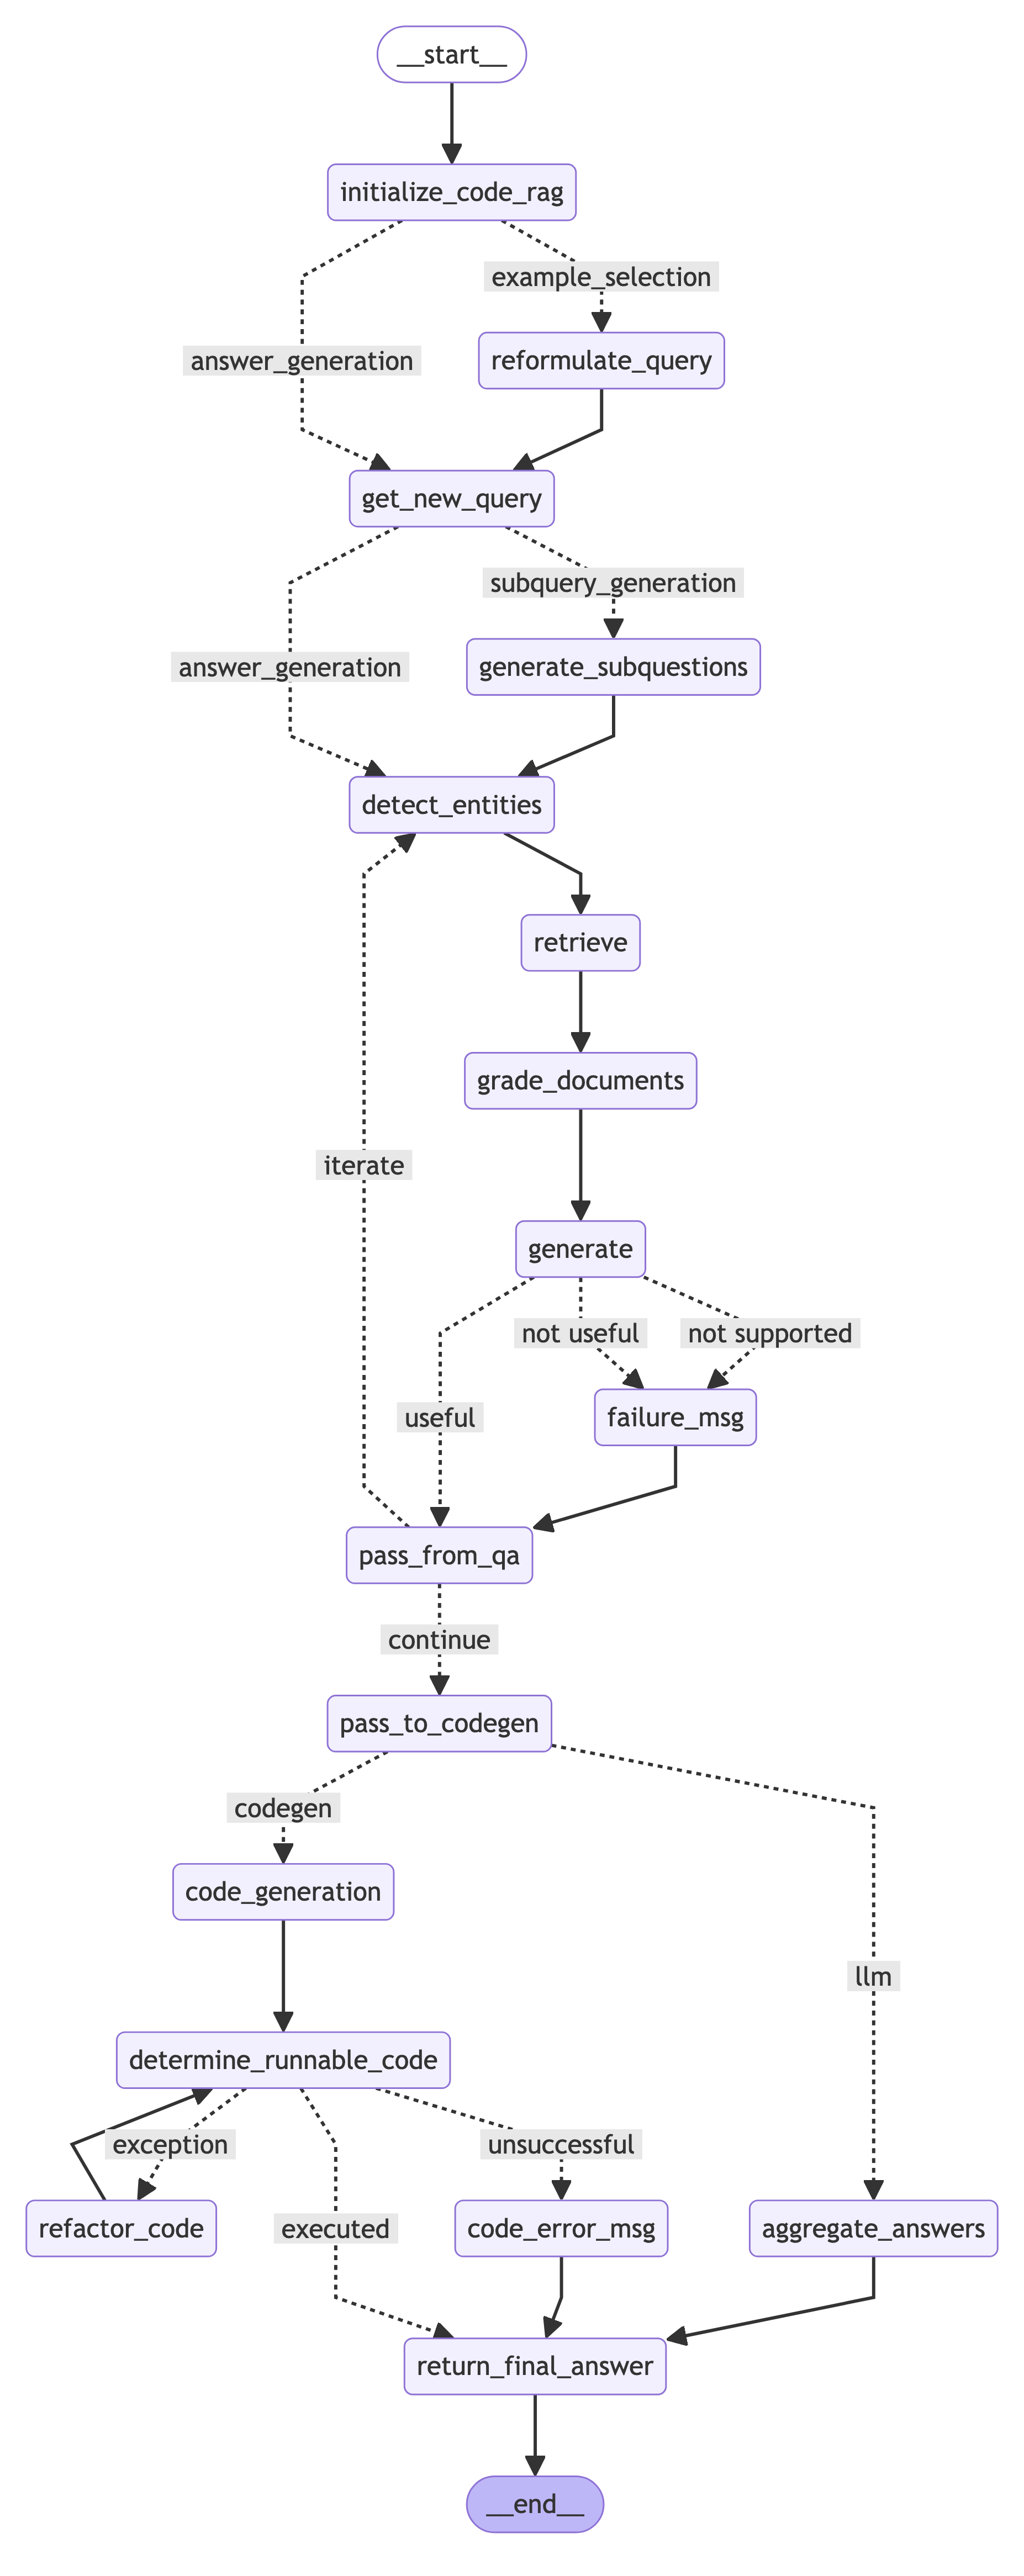

In [5]:
rag.display_graph(app)

## Description of pipeline

This complicated pipeline should demonstrate how seemingly straight forward user queries can require more and more complexity, which in turn means more optimization of agent system prompts, implementations for edge cases, etc.  It is recommended to start developing RAG systems for simple cases along with users and scale up complexity when really needed for user experience.  At some point, there will need to be a tradeoff between user experience/ease of use, latency (long chains will incur more and more calls to LLMs), and development challenges.

### Flow:

After initializing some counters to keep track of coding attempts, etc. The user query encounters the first conditional edge, which is an agent judge that determines, based on the [example router](./../../prompt_engineering/prompts/llama3_8b-prompt_engineering-example_judge.yaml) prompt, if the query needs reformulation or not.  If reformulation is needed, the judge determines the response to be "example selection".  Example selection routes to the reformulate query node. This node calls the reformulate_query method from the RAGComponents class.  This method calls the get_example_selector method to create a retriever for the examples.  After the retriever is instantiated, the get_examples method is called to obtain examples, based on the similarity of the example queries and the user query.  Each example contains a key value pair, which is the expected user query to be reformulated and the reformulated query.  A reformulation chain with the system prompt: [query reformulation](./../../prompt_engineering/prompts/llama3_8b-prompt_engineering-query_reformulation.yaml).  If no reformulation is needed, then the query simply passes to the next node, get_new_query, which is essentially just a pass through node that exists so we can connect a conditional edge to it (conditional edges need to be connected to nodes, not other edges).  

The next conditional edge is another agent judge.  This agent determines if the query is compound in nature and requires query decomposition, via its system prompt [subquery router](./../../prompt_engineering/prompts/llama3_8b-prompt_engineering-subquery_router.yaml).  If subquery generation is required, the query is then routed to the generate subquestions node.  This node calls the generate_subquestion method from RAGComponents, which obtains the question from the current state and passes it to the subquery_chain, which uses the prompt [subquery generation](./../../prompt_engineering/prompts/llama3_8b-prompt_engineering-subquery_generation.yaml).  Subquestions are converted to a list by splitting on new lines and then returned to subquestions in the state as an update.  If no subqueries are required, the query is simply passed along again.  

Either the question or list of subquestions are then passed to a loop, which would be flattened with the use of batch online inference, if latency requirements demand it.  This loop consists of: entity detection, retrieval with metadata filtering, document grading for relevancy, RAG generation, hallucination detection, and answer relevancy determination.  All of these steps ensure that high quality data is received and help to filter out noise when retrieving docuemtns/contexts and that answers are checked to be faithful to the source materials and helpful.  The entity detection is performed via a chain using the [entity determination](./../../prompt_engineering/prompts/llama3_8b-prompt_engineering-entity_determination.yaml) prompt and some logic that handles queries versus subqueries.  Entities are then used at the next node, retrieve, which calls the retrieve_w_filtering of RAGComponents to first filter the vectorstore by the entity name using metadata (simplified as filename, as the front ends typically involve creating vectorstores from files).  If reranking is chosen in the configs (and is recommended if not using a fine tuned embedding model), then reranking will be performed on the documents and they will be resorted.  The initial top k_retrieved_documents is the initial amount of documents to retrieve and rerank, and the final_k_retrieved_documents is the amount of documents to keep and hand to the rest of the chain.  Sequence length of the model is the main factor controlling the final k, as document grading should filter out irrelevant documents.  After documents have been obtained and passed into the graph state, they are then graded for relevancy, which is done by the grade_documents method of RAGComponents.  The grading is done by comparing the query with the document and using the retrieval_grader chain with the [retrieval grading](./../../prompt_engineering/prompts/llama3_8b-prompt_engineering-retrieval_grading.yaml) prompt.  A binary score "yes" or "no" is returned.  If the score is "yes", the document is considered relevant, if "no", it is not.  The grading is then used to filter out irrelevant documents.  Only relevant documents are then passed to the next node, RAG generation.  With the final set of documents, RAG generation is performed at the generate node, which calls the rag_generate method from the RAGComponents class.  This method formats the list of documents into a string separated by new lines and passes the formated documents to the qa_chain.  This chain takes the question (or subquestion) and the formatted documents and is instructed by the [qa](./../../prompt_engineering/prompts/llama3_8b-prompt_engineering-qa.yaml) prompt.  The current generation is updated in the state and appended to the answer list of the state.  A conditional edge is then called to check the generation for both hallucinations (the response should be grounded in the documents) and answer relevancy (the generation should actually answer the question/subquestion).  Hallucinations are checked first.  Documents are formatted, as they were in the generation step, and then passed to the hallucination chain.  The hallucination chain uses the [hallucination detection](./../../prompt_engineering/prompts/llama3_8b-prompt_engineering-hallucination_detection.yaml) prompt to provide the binary score "yes" or "no".  If scored "no", then the generation will be routed to the failure message node.  If "yes", the generation is then checked by the grading chain, which takes the question/subquestion and generation and assess relevancy based on the [retrieval grading](./../../prompt_engineering/prompts/llama3_8b-prompt_engineering-retrieval_grading.yaml) prompt.  The grade is also a binary "yes" or "no".  If "no", then the generation is also passed to the failure message.  If "yes", then the answer/generation is kept as is and the loop continues with the answer(s) appended in the state.  If the answer is deemed as not useful or if it contains hallucinations, the question is passed to the failure_chain that uses the [failure message](./../../prompt_engineering/prompts/llama3_8b-prompt_engineering-code_exec_failure.yaml) prompt to massage the message for the user, which includes providing some suggestions for finding information besides consulting the vectorstore.  

Once the question and/or all subquestions have been answered, there needs to be a determination if simple answer aggregation and summarization is required or if mathematical reasoning is needed to properly answer the question. The pass_to_codegen node collects the original question and sets it again as the question.  This is just done for simple booking keeping purposes.  A conditional edge using the route_question_to_code method from the CodeGenComponents class, is connected to this node.  At this step, the question (the original question now) is passed to the code_router chain with the [code router](./../../prompt_engineering/prompts/llama3_8b-prompt_engineering-code_router.yaml) prompt.  This chain will output either "llm" or "codegen", depending on the nature of the question.  If "llm" is determined, the aggregate answers node will call the aggregate_answers method in RAGComponents.  This method will convert the list of answers to a string seperated by two new lines so they are still somewhat individual and the question (original question) and string formatted list of answers will be passed to the aggregation_chain, which is instructed by the [answer aggregation](../../prompt_engineering/prompts/llama3_8b-prompt_engineering-answer_aggregation.yaml) prompt to answer the question as best and as fully as possible, while also allowing for partial answering over nothing.  If "codegen" is determined, the question and list of answers (formatted as a string) will be passed to the code_generation node.  The node will call the code_generation method from the CodeGenComponents class.  This method takes the questions and formatted list of answers and determines variables from those answers and tries to write code with those varables and the question.  After the code has been written, the parsed Python code snippet is passed to the determine_runnable_code node, which calls both Python REPL and the codegen_qc chain.  *It should be noted that Python REPL can execute arbitrary code on the host machine (e.g., delete files, make network requests). Use with caution.  For more information general security guidelines please see https://python.langchain.com/v0.2/docs/security/.* - From Langchain documentation @ [Python REPL tool](https://python.langchain.com/v0.2/docs/integrations/tools/python/).  If the code can run without an exception it is set as the result.  If an exception occurs, it is caught and set as the result.  Once result is populated, there is some cleanup to prevent chain related exceptions (unfriendly string characters) and it is fed into the codegen_qc chain with instructions from: [codegen_qc](./../../prompt_engineering/prompts/llama3_8b-prompt_engineering-codegen_qc.yaml).  The output of this chain is either "runnable" or "exception" and is fed to the is_runnable state.  At this point there is a conditional edge that calls decide_to_refactor from the CodeGenComponents class.  This method assesses the is_runnable output from the state and returns "executed", "exception", or "unsuccessful".  Both "executed" and "exception" are directly read from the state's last step.  However, "unsuccessful" is determined if the code_counter state variable (which is updated later) reaches the user's set limit via the configuration.  If there is an exception, the code and the exception message will be passed to the refactor_code node and method of the same name in CodeGen Components.  The code_counter will be updated by 1 and the refactor chain using the [code refactor](./../../prompt_engineering/prompts/llama3_8b-prompt_engineering-code_refactor.yaml) prompt will be invoked.  This will attempt to refactor the code, based on the model's codegen capabilities.  What follows is generally similar to the code_generation node.  Python REPL is used to try to run the refactored code.  If the code can run without an exception, the refactor_code method returns the state with updated: code, the resultant generation, and the updated code_counter.  If an exception occurs, the state is returned with updated: code, the error, and an updated code_counter.  The state is then fed back into the determine_runnable_code node to iteratively retry in a loop until either the code has been executed or the code_counter reaches the maximum number of attempts specified in the application configuration by the user.  If the code_counter exceeds the maximum number of attempts, there is routing to the code_error_msg node and method.  The final code and error/exception is then simply passed into a deterministic overall error message.  This message is appended to the answers list.  

To summarize everything that has been done and to answer the original question, the original question and final generation are passed to the final_chain with the [final chain](./../../prompt_engineering/prompts/llama3_8b-prompt_engineering-final_chain.yaml) prompt.  This massages the information into one, final answer.  If the question could not be answered, it provides some suggestionso n how a user may be able to find more information.  

### Considerations

This example should provide insight, through working examples, of how seemingly simple user expectations can balloon into very complicated implementations. Latency, cumulative error, and prompt optimization should all be considered.  It is recommended to build from simple queries to queries with a higher level of complexity and functionality demand as a project or application progresses to keep a healthy check on scaling needs for the application and to know when enough has been implemented.  In many cases, it may be that a hierarchical approach with human in the loop guidance is a better end experience than a very long and involved pipeline, even if latency is reduced via custom hardware, such as SambaNova Systems RDUs due to the other challenges mentioned.  

In [6]:
def run_pipeline(question: str) -> None:
    
    try:
        response = rag.call_rag(app, question, config)
    except Exception as e:
        response = {}
        response["answer"] = str(e)

    display(Markdown("---Response---"))
    display(Markdown(response["answer"]))

    return response["answer"]

Let's run a number of questions of varying levels of complexity and functionality demands and assess where out of the box Llama 3 70B instruct lands for all LLM calls, without fine tuning of either the LLM or embedding model.

In [7]:
questions = [
    "Could the trading price of lyft stock be volatile?",
    "Could the trading price of uber stock be volatile?",
    "What was the difference in revenue for Uber between 2020 and 2021?",
    "What was the difference in revenue for Lyft between 2020 and 2021?",
    "What was the change in revenue for Lyft for 2020 and 2021 as a percentage?",
    "What is 5 + 5?",
    "Provide the business overviews for Uber and Lyft.",
    "What are the growth strategies for Lyft and Uber?",
    "How do the growth strategies differ between Lyft and Uber?",
]

In [8]:
answers = []
for question in questions:
    answers.append(run_pipeline(question))

2024-08-06 09:14:07,732 [INFO] - Method 'use_examples' called on CodeRAG


---Initializing---
Could the trading price of lyft stock be volatile?


2024-08-06 09:14:11,491 [INFO] - Method 'pass_state' called on CodeRAG
2024-08-06 09:14:11,493 [INFO] - Method 'route_question' called on CodeRAG


---Decision---
{'generate_or_example': 'answer_generation'}
---ROUTE ORIGINAL QUESTION---
---ROUTING QUESTION---


2024-08-06 09:14:13,766 [INFO] - Method 'detect_entities' called on CodeRAG


answer_generation
---ROUTE QUESTION TO LLM---
---DETERMINING ENTITIES---


2024-08-06 09:14:15,543 [INFO] - Method 'retrieve_w_filtering' called on CodeRAG


entities:  ['lyft']
['lyft.pdf']
---ANSWERING QUESTION---
Could the trading price of lyft stock be volatile?
---RERANKING DOCUMENTS---


2024-08-06 09:14:34,688 [INFO] - Method 'grade_documents' called on CodeRAG


---NUM DOCUMENTS RETRIEVED---
10
natural disasters, economic downturns, public health crises or political crises;

general macroeconomic conditions;

Operational factors

our limited operating history;

our financial performance and any inability to achieve or maintain profitability in the future;

competition in our industries;

the unpredictability of our results of operations;

uncertainty regarding the growth of the ridesharing and other markets;

our ability to attract and retain qualified drivers and riders;

our insurance coverage and the adequacy of our insurance reserves;

the ability of third-party insurance providers to service our auto-related insurance claims;

our autonomous vehicle technology and the development of the autonomous vehicle industry;

our reputation, brand, and company culture;

illegal or improper activity of users of our platform;

the accuracy of background checks on potential or current drivers;
natural disasters, economic downturns, public health crise

2024-08-06 09:15:00,189 [INFO] - Method 'rag_generate' called on CodeRAG


---GRADE: DOCUMENT RELEVANT---
---GENERATING---
---ANSWERING---
Could the trading price of lyft stock be volatile?
---DOCS---
number of approximate tokens (n words *1.3):  2173.6
natural disasters, economic downturns, public health crises or political crises;

general macroeconomic conditions;

Operational factors

our limited operating history;

our financial performance and any inability to achieve or maintain profitability in the future;

competition in our industries;

the unpredictability of our results of operations;

uncertainty regarding the growth of the ridesharing and other markets;

our ability to attract and retain qualified drivers and riders;

our insurance coverage and the adequacy of our insurance reserves;

the ability of third-party insurance providers to service our auto-related insurance claims;

our autonomous vehicle technology and the development of the autonomous vehicle industry;

our reputation, brand, and company culture;

illegal or improper activity of use

2024-08-06 09:15:02,491 [INFO] - Method 'check_hallucinations' called on CodeRAG


---ANSWER---
Yes, the trading price of Lyft stock could be volatile.
---CHECK FOR HALLUCINATIONS---
{'score': 'yes'}
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---


2024-08-06 09:15:07,140 [INFO] - Method 'pass_state' called on CodeRAG
2024-08-06 09:15:07,141 [INFO] - Method 'determine_cont' called on CodeRAG
2024-08-06 09:15:07,143 [INFO] - Method 'pass_to_codegen' called on CodeRAG


---DECISION: GENERATION ADDRESSES QUESTION---
---FINISHED---
---ROUTE QUESTION---
Could the trading price of lyft stock be volatile?


2024-08-06 09:15:08,689 [INFO] - Method 'aggregate_answers' called on CodeRAG


llm
---ROUTE QUESTION TO LLM---
---ANSWERING---
Could the trading price of lyft stock be volatile?
---INTERMEDIATE ANSWERS---
Yes, the trading price of Lyft stock could be volatile.
---FINAL ANSWER---


2024-08-06 09:15:11,329 [INFO] - Method 'final_answer' called on CodeRAG


Yes, the trading price of Lyft stock could be volatile.
---Final Generation---
Yes, the trading price of Lyft stock could be volatile.


---Response---

Yes, the trading price of Lyft stock could be volatile.

2024-08-06 09:15:13,639 [INFO] - Method 'use_examples' called on CodeRAG


---Initializing---
Could the trading price of uber stock be volatile?


2024-08-06 09:15:16,127 [INFO] - Method 'pass_state' called on CodeRAG
2024-08-06 09:15:16,131 [INFO] - Method 'route_question' called on CodeRAG


---Decision---
{'generate_or_example': 'answer_generation'}
---ROUTE ORIGINAL QUESTION---
---ROUTING QUESTION---


2024-08-06 09:15:18,290 [INFO] - Method 'detect_entities' called on CodeRAG


answer_generation
---ROUTE QUESTION TO LLM---
---DETERMINING ENTITIES---


2024-08-06 09:15:19,248 [INFO] - Method 'retrieve_w_filtering' called on CodeRAG


entities:  ['uber']
['uber.pdf']
---ANSWERING QUESTION---
Could the trading price of uber stock be volatile?
---RERANKING DOCUMENTS---


2024-08-06 09:15:37,595 [INFO] - Method 'grade_documents' called on CodeRAG


---NUM DOCUMENTS RETRIEVED---
10
announcements by us or our competitors of significant products or features, technical innovations, acquisitions, strategic partnerships, joint ventures, or capital commitments;

negative media coverage or publicity;

changes in operating performance and stock market valuations of technology companies generally, or those in our industry in particular, including our competitors;

price and volume fluctuations in the overall stock market, including as a result of trends in the economy as a whole;

lawsuits threatened, filed, or decided against us;

developments in legislation or regulatory actions, including interim or final rulings by judicial or regulatory bodies (including any competition authorities blocking, delaying, or subjecting our pending acquisitions to significant limitations or restrictions on our ability to operate in one or more markets, or requiring us to divest our or any target company’s assets or businesses in one or more markets);

chan

2024-08-06 09:16:08,725 [INFO] - Method 'rag_generate' called on CodeRAG


---GRADE: DOCUMENT RELEVANT---
---GENERATING---
---ANSWERING---
Could the trading price of uber stock be volatile?
---DOCS---
number of approximate tokens (n words *1.3):  1765.4
announcements by us or our competitors of significant products or features, technical innovations, acquisitions, strategic partnerships, joint ventures, or capital commitments;

negative media coverage or publicity;

changes in operating performance and stock market valuations of technology companies generally, or those in our industry in particular, including our competitors;

price and volume fluctuations in the overall stock market, including as a result of trends in the economy as a whole;

lawsuits threatened, filed, or decided against us;

developments in legislation or regulatory actions, including interim or final rulings by judicial or regulatory bodies (including any competition authorities blocking, delaying, or subjecting our pending acquisitions to significant limitations or restrictions on our ab

2024-08-06 09:16:10,974 [INFO] - Method 'check_hallucinations' called on CodeRAG


---ANSWER---
Yes, the trading price of Uber stock could be volatile.
---CHECK FOR HALLUCINATIONS---
{'score': 'yes'}
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---


2024-08-06 09:16:21,153 [INFO] - Method 'pass_state' called on CodeRAG
2024-08-06 09:16:21,155 [INFO] - Method 'determine_cont' called on CodeRAG
2024-08-06 09:16:21,158 [INFO] - Method 'pass_to_codegen' called on CodeRAG


---DECISION: GENERATION ADDRESSES QUESTION---
---FINISHED---
---ROUTE QUESTION---
Could the trading price of uber stock be volatile?


2024-08-06 09:16:22,538 [INFO] - Method 'aggregate_answers' called on CodeRAG


llm
---ROUTE QUESTION TO LLM---
---ANSWERING---
Could the trading price of uber stock be volatile?
---INTERMEDIATE ANSWERS---
Yes, the trading price of Uber stock could be volatile.
---FINAL ANSWER---


2024-08-06 09:16:23,993 [INFO] - Method 'final_answer' called on CodeRAG


Yes, the trading price of Uber stock could be volatile.
---Final Generation---
Yes, the trading price of Uber stock could be volatile.


---Response---

Yes, the trading price of Uber stock could be volatile.

2024-08-06 09:16:25,594 [INFO] - Method 'use_examples' called on CodeRAG


---Initializing---
What was the difference in revenue for Uber between 2020 and 2021?


2024-08-06 09:16:26,552 [INFO] - Method 'pass_state' called on CodeRAG
2024-08-06 09:16:26,554 [INFO] - Method 'route_question' called on CodeRAG


---Decision---
{'generate_or_example': 'answer_generation'}
---ROUTE ORIGINAL QUESTION---
---ROUTING QUESTION---


2024-08-06 09:16:27,516 [INFO] - Method 'generate_subquestions' called on CodeRAG


subquery_generation
---ROUTE QUESTION TO SUBQUERY_GENERATION---


2024-08-06 09:16:28,775 [INFO] - Method 'detect_entities' called on CodeRAG


---SUBQUESTIONS---
• What was the revenue for Uber in 2020?
• What was the revenue for Uber in 2021?
---DETERMINING ENTITIES---


2024-08-06 09:16:29,756 [INFO] - Method 'retrieve_w_filtering' called on CodeRAG


entities:  ['Uber']
['uber.pdf']
---ANSWERING SUBQUESTIONS---
• What was the revenue for Uber in 2020?
---RERANKING DOCUMENTS---


2024-08-06 09:16:46,789 [INFO] - Method 'grade_documents' called on CodeRAG


---NUM DOCUMENTS RETRIEVED---
10
Note 2 – Revenue

The following tables present our revenues disaggregated by offering and geographical region. Revenue by geographical region is based on where the transaction occurred. This level of disaggregation takes into consideration how the nature, amount, timing, and uncertainty of revenue and cash flows are affected by economic factors. Revenue is presented in the following tables for the years ended December 31, 2019, 2020 and 2021, respectively (in millions):

2019

Year Ended December 31, 2020

Mobility revenue Delivery revenue Freight revenue All Other revenue

(1)

(1)

Total revenue

$

$

10,707 $ 1,401 731 161 13,000 $

6,089 $ 3,904 1,011 135 11,139 $

(1)

We offer subscription memberships to end-users including Uber One, Uber Pass, Rides Pass, and Eats Pass (“Subscription”). We recognize Subscription fees ratably over the life of the pass. We allocate Subscription fees earned to Mobility and Delivery revenue on a proportional basis, 

2024-08-06 09:17:00,285 [INFO] - Method 'rag_generate' called on CodeRAG


---GRADE: DOCUMENT NOT RELEVANT---
---GENERATING---
---ANSWERING---
• What was the revenue for Uber in 2020?
---DOCS---
number of approximate tokens (n words *1.3):  924.3000000000001
Note 2 – Revenue

The following tables present our revenues disaggregated by offering and geographical region. Revenue by geographical region is based on where the transaction occurred. This level of disaggregation takes into consideration how the nature, amount, timing, and uncertainty of revenue and cash flows are affected by economic factors. Revenue is presented in the following tables for the years ended December 31, 2019, 2020 and 2021, respectively (in millions):

2019

Year Ended December 31, 2020

Mobility revenue Delivery revenue Freight revenue All Other revenue

(1)

(1)

Total revenue

$

$

10,707 $ 1,401 731 161 13,000 $

6,089 $ 3,904 1,011 135 11,139 $

(1)

We offer subscription memberships to end-users including Uber One, Uber Pass, Rides Pass, and Eats Pass (“Subscription”). We recogni

2024-08-06 09:17:02,912 [INFO] - Method 'check_hallucinations' called on CodeRAG


---ANSWER---
The revenue for Uber in 2020 was $11,139 million.
---CHECK FOR HALLUCINATIONS---
{'score': 'yes'}
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---


2024-08-06 09:17:05,907 [INFO] - Method 'pass_state' called on CodeRAG
2024-08-06 09:17:05,908 [INFO] - Method 'determine_cont' called on CodeRAG
2024-08-06 09:17:05,910 [INFO] - Method 'detect_entities' called on CodeRAG


---DECISION: GENERATION ADDRESSES QUESTION---
---ITERATING ON RAG CHAIN---
---DETERMINING ENTITIES---


2024-08-06 09:17:07,440 [INFO] - Method 'retrieve_w_filtering' called on CodeRAG


entities:  ['Uber', '2021']
['uber.pdf', '2021.pdf']
---ANSWERING SUBQUESTIONS---
• What was the revenue for Uber in 2021?
---RERANKING DOCUMENTS---


2024-08-06 09:17:24,343 [INFO] - Method 'grade_documents' called on CodeRAG


---NUM DOCUMENTS RETRIEVED---
10
As described in Notes 1 and 2 to the consolidated financial statements, the Company derives its revenues principally from Drivers’ and Merchants’ use of the Company’s platform, on-demand lead generation, and related services in connection with Mobility and Delivery services, as well as from direct fees charged to end-users for use of the platform and in exchange for Delivery services. Management applies judgment in determining whether the Company is the principal or agent in transactions with Drivers, Merchants and end-users. This determination impacts the presentation of revenue on a gross or net basis as well as the presentation of incentives provided to Drivers and Merchants and discounts and promotions offered to end-users, to the extent they are not customers. For the year ended December 31, 2021, the Company’s Mobility and Delivery revenue, net of incentives, was $15.3 billion and discounts, loyalty programs, promotions, refunds, and credits provi

2024-08-06 09:17:35,343 [INFO] - Method 'rag_generate' called on CodeRAG


---GRADE: DOCUMENT NOT RELEVANT---
---GENERATING---
---ANSWERING---
• What was the revenue for Uber in 2021?
---DOCS---
number of approximate tokens (n words *1.3):  813.8000000000001
As described in Notes 1 and 2 to the consolidated financial statements, the Company derives its revenues principally from Drivers’ and Merchants’ use of the Company’s platform, on-demand lead generation, and related services in connection with Mobility and Delivery services, as well as from direct fees charged to end-users for use of the platform and in exchange for Delivery services. Management applies judgment in determining whether the Company is the principal or agent in transactions with Drivers, Merchants and end-users. This determination impacts the presentation of revenue on a gross or net basis as well as the presentation of incentives provided to Drivers and Merchants and discounts and promotions offered to end-users, to the extent they are not customers. For the year ended December 31, 2021, th

2024-08-06 09:17:36,920 [INFO] - Method 'check_hallucinations' called on CodeRAG


---ANSWER---
The revenue for Uber in 2021 was $17,455 million.
---CHECK FOR HALLUCINATIONS---
{'score': 'yes'}
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---


2024-08-06 09:17:39,612 [INFO] - Method 'pass_state' called on CodeRAG
2024-08-06 09:17:39,615 [INFO] - Method 'determine_cont' called on CodeRAG
2024-08-06 09:17:39,618 [INFO] - Method 'pass_to_codegen' called on CodeRAG


---DECISION: GENERATION ADDRESSES QUESTION---
---FINISHED---
---ROUTE QUESTION---
What was the difference in revenue for Uber between 2020 and 2021?


2024-08-06 09:17:41,022 [INFO] - Method 'code_generation' called on CodeRAG


codegen
---ROUTE QUESTION TO CODEGEN---
---GENERATING CODE---
What was the difference in revenue for Uber between 2020 and 2021?


2024-08-06 09:17:43,479 [INFO] - Method 'determine_runnable_code' called on CodeRAG
2024-08-06 09:17:43,479 [WARNING] - Python REPL can execute arbitrary code. Use with caution.


Generated code: 
 revenue_2020 = 11139
revenue_2021 = 17455

difference = revenue_2021 - revenue_2020

print("The difference in revenue for Uber between 2020 and 2021 was ${} million.".format(difference))
---QCING CODE---
The difference in revenue for Uber between 2020 and 2021 was $6316 million.



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2024-08-06 09:17:44,910 [INFO] - Method 'decide_to_refactor' called on CodeRAG
2024-08-06 09:17:44,915 [INFO] - Method 'final_answer' called on CodeRAG


{'runnable': 'executed'}
Code status:  executed
---DETERMINING IF REFACTOR IS NEEDED---
Attempt:  0
executed
---EXECUTABLE---
---Final Generation---
The difference in revenue for Uber between 2020 and 2021 was $6316 million.



---Response---

The difference in revenue for Uber between 2020 and 2021 was $6316 million.

2024-08-06 09:17:46,751 [INFO] - Method 'use_examples' called on CodeRAG


---Initializing---
What was the difference in revenue for Lyft between 2020 and 2021?


2024-08-06 09:17:48,139 [INFO] - Method 'pass_state' called on CodeRAG
2024-08-06 09:17:48,142 [INFO] - Method 'route_question' called on CodeRAG


---Decision---
{'generate_or_example': 'answer_generation'}
---ROUTE ORIGINAL QUESTION---
---ROUTING QUESTION---


2024-08-06 09:17:49,536 [INFO] - Method 'generate_subquestions' called on CodeRAG


subquery_generation
---ROUTE QUESTION TO SUBQUERY_GENERATION---


2024-08-06 09:17:51,426 [INFO] - Method 'detect_entities' called on CodeRAG


---SUBQUESTIONS---
• What was the revenue for Lyft in 2020?
• What was the revenue for Lyft in 2021?
---DETERMINING ENTITIES---


2024-08-06 09:17:52,474 [INFO] - Method 'retrieve_w_filtering' called on CodeRAG


entities:  ['Lyft', '2020']
['lyft.pdf', '2020.pdf']
---ANSWERING SUBQUESTIONS---
• What was the revenue for Lyft in 2020?
---RERANKING DOCUMENTS---


2024-08-06 09:18:12,153 [INFO] - Method 'grade_documents' called on CodeRAG


---NUM DOCUMENTS RETRIEVED---
10
Lyft, Inc. Consolidated Statements of Cash Flows (in thousands)

2021

Cash flows from operating activities Net loss Adjustments to reconcile net loss to net cash used in operating activities

$

(1,009,359)

Depreciation and amortization Stock-based compensation Amortization of premium on marketable securities Accretion of discount on marketable securities Amortization of debt discount and issuance costs Deferred income tax from convertible senior notes Loss on sale and disposal of assets, net Gain on divestiture Other Changes in operating assets and liabilities, net effects of acquisition

139,347 724,560 4,100 (1,513) 35,575 — 5,538 (119,284) 3,321

Prepaid expenses and other assets Operating lease right-of-use assets Accounts payable Insurance reserves Accrued and other liabilities Lease liabilities

(207,046) 61,301 47,080 81,564 181,427 (48,332)

Net cash used in operating activities

(101,721)

Cash flows from investing activities Purchases of ma

2024-08-06 09:18:26,618 [INFO] - Method 'rag_generate' called on CodeRAG


---GRADE: DOCUMENT NOT RELEVANT---
---GENERATING---
---ANSWERING---
• What was the revenue for Lyft in 2020?
---DOCS---
number of approximate tokens (n words *1.3):  1125.8
8,977,061 (473) (7,300,428) 1,676,163 4,678,964

Lyft, Inc. Consolidated Statements of Operations (in thousands, except for per share data)

Revenue Costs and expenses Cost of revenue Operations and support Research and development Sales and marketing General and administrative Total costs and expenses Loss from operations

Interest expense Other income, net

Loss before income taxes

Provision for (benefit from) income taxes

$

Year Ended December 31, 2020 2,364,681 $

2021 3,208,323 $

1,649,532 402,233 911,946 411,406 915,638 4,290,755 (1,082,432) (51,635) 135,933 (998,134) 11,225 (1,009,359) $

1,447,516 453,963 909,126 416,331 946,127 4,173,063 (1,808,382) (32,678) 43,669 (1,797,391) (44,534) (1,752,857) $

Net loss

$

Net loss per share, basic and diluted

$

(3.02) $

(5.61) $

Weighted-average number of sh

2024-08-06 09:18:28,145 [INFO] - Method 'check_hallucinations' called on CodeRAG


---ANSWER---
The revenue for Lyft in 2020 was $2,364,681.
---CHECK FOR HALLUCINATIONS---
{'score': 'yes'}
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---


2024-08-06 09:18:30,934 [INFO] - Method 'pass_state' called on CodeRAG
2024-08-06 09:18:30,937 [INFO] - Method 'determine_cont' called on CodeRAG
2024-08-06 09:18:30,940 [INFO] - Method 'detect_entities' called on CodeRAG


---DECISION: GENERATION ADDRESSES QUESTION---
---ITERATING ON RAG CHAIN---
---DETERMINING ENTITIES---


2024-08-06 09:18:33,502 [INFO] - Method 'retrieve_w_filtering' called on CodeRAG


entities:  ['Lyft', '2021']
['lyft.pdf', '2021.pdf']
---ANSWERING SUBQUESTIONS---
• What was the revenue for Lyft in 2021?
---RERANKING DOCUMENTS---


2024-08-06 09:18:48,946 [INFO] - Method 'grade_documents' called on CodeRAG


---NUM DOCUMENTS RETRIEVED---
10
Lyft, Inc. Consolidated Statements of Cash Flows (in thousands)

2021

Cash flows from operating activities Net loss Adjustments to reconcile net loss to net cash used in operating activities

$

(1,009,359)

Depreciation and amortization Stock-based compensation Amortization of premium on marketable securities Accretion of discount on marketable securities Amortization of debt discount and issuance costs Deferred income tax from convertible senior notes Loss on sale and disposal of assets, net Gain on divestiture Other Changes in operating assets and liabilities, net effects of acquisition

139,347 724,560 4,100 (1,513) 35,575 — 5,538 (119,284) 3,321

Prepaid expenses and other assets Operating lease right-of-use assets Accounts payable Insurance reserves Accrued and other liabilities Lease liabilities

(207,046) 61,301 47,080 81,564 181,427 (48,332)

Net cash used in operating activities

(101,721)

Cash flows from investing activities Purchases of ma

2024-08-06 09:18:59,384 [INFO] - Method 'rag_generate' called on CodeRAG


---GRADE: DOCUMENT NOT RELEVANT---
---GENERATING---
---ANSWERING---
• What was the revenue for Lyft in 2021?
---DOCS---
number of approximate tokens (n words *1.3):  933.4
8,977,061 (473) (7,300,428) 1,676,163 4,678,964

Lyft, Inc. Consolidated Statements of Operations (in thousands, except for per share data)

Revenue Costs and expenses Cost of revenue Operations and support Research and development Sales and marketing General and administrative Total costs and expenses Loss from operations

Interest expense Other income, net

Loss before income taxes

Provision for (benefit from) income taxes

$

Year Ended December 31, 2020 2,364,681 $

2021 3,208,323 $

1,649,532 402,233 911,946 411,406 915,638 4,290,755 (1,082,432) (51,635) 135,933 (998,134) 11,225 (1,009,359) $

1,447,516 453,963 909,126 416,331 946,127 4,173,063 (1,808,382) (32,678) 43,669 (1,797,391) (44,534) (1,752,857) $

Net loss

$

Net loss per share, basic and diluted

$

(3.02) $

(5.61) $

Weighted-average number of sha

2024-08-06 09:19:01,032 [INFO] - Method 'check_hallucinations' called on CodeRAG


---ANSWER---
The revenue for Lyft in 2021 was $3,208,323.
---CHECK FOR HALLUCINATIONS---
{'score': 'yes'}
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---


2024-08-06 09:19:03,787 [INFO] - Method 'pass_state' called on CodeRAG
2024-08-06 09:19:03,791 [INFO] - Method 'determine_cont' called on CodeRAG
2024-08-06 09:19:03,801 [INFO] - Method 'pass_to_codegen' called on CodeRAG


---DECISION: GENERATION ADDRESSES QUESTION---
---FINISHED---
---ROUTE QUESTION---
What was the difference in revenue for Lyft between 2020 and 2021?


2024-08-06 09:19:05,183 [INFO] - Method 'code_generation' called on CodeRAG


codegen
---ROUTE QUESTION TO CODEGEN---
---GENERATING CODE---
What was the difference in revenue for Lyft between 2020 and 2021?


2024-08-06 09:19:07,601 [INFO] - Method 'determine_runnable_code' called on CodeRAG


Generated code: 
 revenue_2020 = 2364681
revenue_2021 = 3208323

difference = revenue_2021 - revenue_2020

print("The difference in revenue for Lyft between 2020 and 2021 is $", difference)
---QCING CODE---
The difference in revenue for Lyft between 2020 and 2021 is $ 843642



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2024-08-06 09:19:08,978 [INFO] - Method 'decide_to_refactor' called on CodeRAG
2024-08-06 09:19:08,982 [INFO] - Method 'final_answer' called on CodeRAG


{'runnable': 'executed'}
Code status:  executed
---DETERMINING IF REFACTOR IS NEEDED---
Attempt:  0
executed
---EXECUTABLE---
---Final Generation---
The difference in revenue for Lyft between 2020 and 2021 is $ 843642



---Response---

The difference in revenue for Lyft between 2020 and 2021 is $843,642.

2024-08-06 09:19:10,702 [INFO] - Method 'use_examples' called on CodeRAG


---Initializing---
What was the change in revenue for Lyft for 2020 and 2021 as a percentage?


2024-08-06 09:19:12,294 [INFO] - Method 'pass_state' called on CodeRAG
2024-08-06 09:19:12,297 [INFO] - Method 'route_question' called on CodeRAG


---Decision---
{'generate_or_example': 'answer_generation'}
---ROUTE ORIGINAL QUESTION---
---ROUTING QUESTION---


2024-08-06 09:19:13,759 [INFO] - Method 'generate_subquestions' called on CodeRAG


subquery_generation
---ROUTE QUESTION TO SUBQUERY_GENERATION---


2024-08-06 09:19:15,445 [INFO] - Method 'detect_entities' called on CodeRAG


---SUBQUESTIONS---
• What was the revenue for Lyft in 2020?
• What was the revenue for Lyft in 2021?
---DETERMINING ENTITIES---


2024-08-06 09:19:17,083 [INFO] - Method 'retrieve_w_filtering' called on CodeRAG


entities:  ['Lyft', '2020']
['lyft.pdf', '2020.pdf']
---ANSWERING SUBQUESTIONS---
• What was the revenue for Lyft in 2020?
---RERANKING DOCUMENTS---


2024-08-06 09:19:35,149 [INFO] - Method 'grade_documents' called on CodeRAG


---NUM DOCUMENTS RETRIEVED---
10
Lyft, Inc. Consolidated Statements of Cash Flows (in thousands)

2021

Cash flows from operating activities Net loss Adjustments to reconcile net loss to net cash used in operating activities

$

(1,009,359)

Depreciation and amortization Stock-based compensation Amortization of premium on marketable securities Accretion of discount on marketable securities Amortization of debt discount and issuance costs Deferred income tax from convertible senior notes Loss on sale and disposal of assets, net Gain on divestiture Other Changes in operating assets and liabilities, net effects of acquisition

139,347 724,560 4,100 (1,513) 35,575 — 5,538 (119,284) 3,321

Prepaid expenses and other assets Operating lease right-of-use assets Accounts payable Insurance reserves Accrued and other liabilities Lease liabilities

(207,046) 61,301 47,080 81,564 181,427 (48,332)

Net cash used in operating activities

(101,721)

Cash flows from investing activities Purchases of ma

2024-08-06 09:19:48,974 [INFO] - Method 'rag_generate' called on CodeRAG


---GRADE: DOCUMENT NOT RELEVANT---
---GENERATING---
---ANSWERING---
• What was the revenue for Lyft in 2020?
---DOCS---
number of approximate tokens (n words *1.3):  1125.8
8,977,061 (473) (7,300,428) 1,676,163 4,678,964

Lyft, Inc. Consolidated Statements of Operations (in thousands, except for per share data)

Revenue Costs and expenses Cost of revenue Operations and support Research and development Sales and marketing General and administrative Total costs and expenses Loss from operations

Interest expense Other income, net

Loss before income taxes

Provision for (benefit from) income taxes

$

Year Ended December 31, 2020 2,364,681 $

2021 3,208,323 $

1,649,532 402,233 911,946 411,406 915,638 4,290,755 (1,082,432) (51,635) 135,933 (998,134) 11,225 (1,009,359) $

1,447,516 453,963 909,126 416,331 946,127 4,173,063 (1,808,382) (32,678) 43,669 (1,797,391) (44,534) (1,752,857) $

Net loss

$

Net loss per share, basic and diluted

$

(3.02) $

(5.61) $

Weighted-average number of sh

2024-08-06 09:19:50,776 [INFO] - Method 'check_hallucinations' called on CodeRAG


---ANSWER---
The revenue for Lyft in 2020 was $2,364,681.
---CHECK FOR HALLUCINATIONS---
{'score': 'yes'}
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---


2024-08-06 09:19:53,581 [INFO] - Method 'pass_state' called on CodeRAG
2024-08-06 09:19:53,583 [INFO] - Method 'determine_cont' called on CodeRAG
2024-08-06 09:19:53,586 [INFO] - Method 'detect_entities' called on CodeRAG


---DECISION: GENERATION ADDRESSES QUESTION---
---ITERATING ON RAG CHAIN---
---DETERMINING ENTITIES---


2024-08-06 09:19:55,092 [INFO] - Method 'retrieve_w_filtering' called on CodeRAG


entities:  ['Lyft', '2021']
['lyft.pdf', '2021.pdf']
---ANSWERING SUBQUESTIONS---
• What was the revenue for Lyft in 2021?
---RERANKING DOCUMENTS---


2024-08-06 09:20:07,665 [INFO] - Method 'grade_documents' called on CodeRAG


---NUM DOCUMENTS RETRIEVED---
10
Lyft, Inc. Consolidated Statements of Cash Flows (in thousands)

2021

Cash flows from operating activities Net loss Adjustments to reconcile net loss to net cash used in operating activities

$

(1,009,359)

Depreciation and amortization Stock-based compensation Amortization of premium on marketable securities Accretion of discount on marketable securities Amortization of debt discount and issuance costs Deferred income tax from convertible senior notes Loss on sale and disposal of assets, net Gain on divestiture Other Changes in operating assets and liabilities, net effects of acquisition

139,347 724,560 4,100 (1,513) 35,575 — 5,538 (119,284) 3,321

Prepaid expenses and other assets Operating lease right-of-use assets Accounts payable Insurance reserves Accrued and other liabilities Lease liabilities

(207,046) 61,301 47,080 81,564 181,427 (48,332)

Net cash used in operating activities

(101,721)

Cash flows from investing activities Purchases of ma

2024-08-06 09:20:26,249 [INFO] - Method 'rag_generate' called on CodeRAG


---GRADE: DOCUMENT NOT RELEVANT---
---GENERATING---
---ANSWERING---
• What was the revenue for Lyft in 2021?
---DOCS---
number of approximate tokens (n words *1.3):  933.4
8,977,061 (473) (7,300,428) 1,676,163 4,678,964

Lyft, Inc. Consolidated Statements of Operations (in thousands, except for per share data)

Revenue Costs and expenses Cost of revenue Operations and support Research and development Sales and marketing General and administrative Total costs and expenses Loss from operations

Interest expense Other income, net

Loss before income taxes

Provision for (benefit from) income taxes

$

Year Ended December 31, 2020 2,364,681 $

2021 3,208,323 $

1,649,532 402,233 911,946 411,406 915,638 4,290,755 (1,082,432) (51,635) 135,933 (998,134) 11,225 (1,009,359) $

1,447,516 453,963 909,126 416,331 946,127 4,173,063 (1,808,382) (32,678) 43,669 (1,797,391) (44,534) (1,752,857) $

Net loss

$

Net loss per share, basic and diluted

$

(3.02) $

(5.61) $

Weighted-average number of sha

2024-08-06 09:20:27,354 [INFO] - Method 'check_hallucinations' called on CodeRAG


---ANSWER---
The revenue for Lyft in 2021 was $3,208,323.
---CHECK FOR HALLUCINATIONS---
{'score': 'yes'}
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---


2024-08-06 09:20:29,184 [INFO] - Method 'pass_state' called on CodeRAG
2024-08-06 09:20:29,187 [INFO] - Method 'determine_cont' called on CodeRAG
2024-08-06 09:20:29,190 [INFO] - Method 'pass_to_codegen' called on CodeRAG


---DECISION: GENERATION ADDRESSES QUESTION---
---FINISHED---
---ROUTE QUESTION---
What was the change in revenue for Lyft for 2020 and 2021 as a percentage?


2024-08-06 09:20:30,109 [INFO] - Method 'code_generation' called on CodeRAG


codegen
---ROUTE QUESTION TO CODEGEN---
---GENERATING CODE---
What was the change in revenue for Lyft for 2020 and 2021 as a percentage?


2024-08-06 09:20:32,504 [INFO] - Method 'determine_runnable_code' called on CodeRAG


Generated code: 
 revenue_2020 = 2364681
revenue_2021 = 3208323

change_in_revenue = revenue_2021 - revenue_2020
percentage_change = (change_in_revenue / revenue_2020) * 100

print(f"The change in revenue for Lyft from 2020 to 2021 is {percentage_change:.2f}%")
---QCING CODE---
The change in revenue for Lyft from 2020 to 2021 is 35.68%



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2024-08-06 09:20:33,605 [INFO] - Method 'decide_to_refactor' called on CodeRAG
2024-08-06 09:20:33,607 [INFO] - Method 'final_answer' called on CodeRAG


{'runnable': 'executed'}
Code status:  executed
---DETERMINING IF REFACTOR IS NEEDED---
Attempt:  0
executed
---EXECUTABLE---
---Final Generation---
The change in revenue for Lyft from 2020 to 2021 is 35.68%



---Response---

The change in revenue for Lyft from 2020 to 2021 is 35.68%.

2024-08-06 09:20:34,779 [INFO] - Method 'use_examples' called on CodeRAG


---Initializing---
What is 5 + 5?


2024-08-06 09:20:36,358 [INFO] - Method 'pass_state' called on CodeRAG
2024-08-06 09:20:36,360 [INFO] - Method 'route_question' called on CodeRAG


---Decision---
{'generate_or_example': 'answer_generation'}
---ROUTE ORIGINAL QUESTION---
---ROUTING QUESTION---


2024-08-06 09:20:37,793 [INFO] - Method 'detect_entities' called on CodeRAG


answer_generation
---ROUTE QUESTION TO LLM---
---DETERMINING ENTITIES---


2024-08-06 09:20:39,204 [INFO] - Method 'retrieve_w_filtering' called on CodeRAG


entities:  []
[]
---ANSWERING QUESTION---
What is 5 + 5?
---RERANKING DOCUMENTS---


2024-08-06 09:20:41,150 [INFO] - Method 'grade_documents' called on CodeRAG
2024-08-06 09:20:41,152 [INFO] - Method 'rag_generate' called on CodeRAG


---NUM DOCUMENTS RETRIEVED---
0
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GENERATING---
---ANSWERING---
What is 5 + 5?
---DOCS---
number of approximate tokens (n words *1.3):  0.0



2024-08-06 09:20:42,357 [INFO] - Method 'check_hallucinations' called on CodeRAG


---ANSWER---
10
---CHECK FOR HALLUCINATIONS---


2024-08-06 09:20:43,691 [INFO] - Method 'failure_msg' called on CodeRAG


{'score': 'no'}
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS---


2024-08-06 09:20:49,418 [INFO] - Method 'pass_state' called on CodeRAG
2024-08-06 09:20:49,421 [INFO] - Method 'determine_cont' called on CodeRAG
2024-08-06 09:20:49,424 [INFO] - Method 'pass_to_codegen' called on CodeRAG


---FINISHED---
---ROUTE QUESTION---
What is 5 + 5?


2024-08-06 09:20:50,792 [INFO] - Method 'code_generation' called on CodeRAG


codegen
---ROUTE QUESTION TO CODEGEN---
---GENERATING CODE---
What is 5 + 5?


2024-08-06 09:20:52,541 [INFO] - Method 'determine_runnable_code' called on CodeRAG


Generated code: 
 print("The answer to 5 + 5 is:", 5 + 5)
---QCING CODE---
The answer to 5 + 5 is: 10



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2024-08-06 09:20:55,330 [INFO] - Method 'decide_to_refactor' called on CodeRAG
2024-08-06 09:20:55,333 [INFO] - Method 'final_answer' called on CodeRAG


{'runnable': 'executed'}
Code status:  executed
---DETERMINING IF REFACTOR IS NEEDED---
Attempt:  0
executed
---EXECUTABLE---
---Final Generation---
The answer to 5 + 5 is: 10



---Response---

The answer to 5 + 5 is 10.

2024-08-06 09:20:56,876 [INFO] - Method 'use_examples' called on CodeRAG


---Initializing---
Provide the business overviews for Uber and Lyft.


2024-08-06 09:20:58,375 [INFO] - Method 'pass_state' called on CodeRAG
2024-08-06 09:20:58,377 [INFO] - Method 'route_question' called on CodeRAG


---Decision---
{'generate_or_example': 'answer_generation'}
---ROUTE ORIGINAL QUESTION---
---ROUTING QUESTION---


2024-08-06 09:20:59,935 [INFO] - Method 'generate_subquestions' called on CodeRAG


subquery_generation
---ROUTE QUESTION TO SUBQUERY_GENERATION---


2024-08-06 09:21:01,072 [INFO] - Method 'detect_entities' called on CodeRAG


---SUBQUESTIONS---
• What is the business overview for Uber?
• What is the business overview for Lyft?
---DETERMINING ENTITIES---


2024-08-06 09:21:02,026 [INFO] - Method 'retrieve_w_filtering' called on CodeRAG


entities:  Uber
['uber.pdf']
---ANSWERING SUBQUESTIONS---
• What is the business overview for Uber?
---RERANKING DOCUMENTS---


2024-08-06 09:21:14,513 [INFO] - Method 'grade_documents' called on CodeRAG


---NUM DOCUMENTS RETRIEVED---
10
Overview

Uber Technologies, Inc. (“Uber,” “we,” “our,” or “us”) is a technology platform that uses a massive network, leading technology, operational excellence and product expertise to power movement from point A to point B. We develop and operate proprietary technology applications supporting a variety of offerings on our platform (“platform(s)” or “Platform(s)”). We connect consumers (“Rider(s)”) with independent providers of ride services (“Mobility Driver(s)”) for ridesharing services, and connect Riders and other consumers (“Eater(s)”) with restaurants, grocers and other stores (collectively, “Merchants”) with delivery service providers (“Couriers”) for meal preparation, grocery and other delivery services. Riders and Eaters are collectively referred to as “end-user(s)” or “consumer(s).” Mobility Drivers and Couriers are collectively referred to as “Driver(s).” We also connect consumers with public transportation networks. We use this same networ

2024-08-06 09:21:29,846 [INFO] - Method 'rag_generate' called on CodeRAG


---GRADE: DOCUMENT RELEVANT---
---GENERATING---
---ANSWERING---
• What is the business overview for Uber?
---DOCS---
number of approximate tokens (n words *1.3):  2028.0
Overview

Uber Technologies, Inc. (“Uber,” “we,” “our,” or “us”) is a technology platform that uses a massive network, leading technology, operational excellence and product expertise to power movement from point A to point B. We develop and operate proprietary technology applications supporting a variety of offerings on our platform (“platform(s)” or “Platform(s)”). We connect consumers (“Rider(s)”) with independent providers of ride services (“Mobility Driver(s)”) for ridesharing services, and connect Riders and other consumers (“Eater(s)”) with restaurants, grocers and other stores (collectively, “Merchants”) with delivery service providers (“Couriers”) for meal preparation, grocery and other delivery services. Riders and Eaters are collectively referred to as “end-user(s)” or “consumer(s).” Mobility Drivers and Cou

2024-08-06 09:21:35,720 [INFO] - Method 'check_hallucinations' called on CodeRAG


---ANSWER---
Uber is a technology platform that uses a massive network, leading technology, operational excellence, and product expertise to power movement from point A to point B. It connects consumers with independent providers of ride services, restaurants, grocers, and other stores for meal preparation, grocery, and other delivery services, as well as with public transportation networks and shippers with carriers in the freight industry.
---CHECK FOR HALLUCINATIONS---
{'score': 'yes'}
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---


2024-08-06 09:21:41,598 [INFO] - Method 'pass_state' called on CodeRAG
2024-08-06 09:21:41,602 [INFO] - Method 'determine_cont' called on CodeRAG
2024-08-06 09:21:41,606 [INFO] - Method 'detect_entities' called on CodeRAG


---DECISION: GENERATION ADDRESSES QUESTION---
---ITERATING ON RAG CHAIN---
---DETERMINING ENTITIES---


2024-08-06 09:21:43,126 [INFO] - Method 'retrieve_w_filtering' called on CodeRAG


entities:  Lyft
['lyft.pdf']
---ANSWERING SUBQUESTIONS---
• What is the business overview for Lyft?
---RERANKING DOCUMENTS---


2024-08-06 09:21:55,598 [INFO] - Method 'grade_documents' called on CodeRAG


---NUM DOCUMENTS RETRIEVED---
10
Our Mission

Improve people’s lives with the world’s best transportation.

Overview

Lyft, Inc (the “Company” or “Lyft”) started a movement to revolutionize transportation. In 2012, we launched our peer-to-peer marketplace for on-demand ridesharing and have continued to pioneer innovations aligned with our mission. Today, Lyft is one of the largest multimodal transportation networks in the United States and Canada.

We believe that the world is at the beginning of a shift away from car ownership to Transportation-as-a-Service (“TaaS”). Lyft is at the forefront of this massive societal change. Our ridesharing marketplace connects drivers with riders via the Lyft mobile application (the “Lyft App”) in cities across the United States and in select cities in Canada. We believe that our ridesharing marketplace allows riders to use their cars less and offers a viable alternative to car ownership while providing drivers using our platform the freedom and indep

2024-08-06 09:22:08,159 [INFO] - Method 'rag_generate' called on CodeRAG


---GRADE: DOCUMENT NOT RELEVANT---
---GENERATING---
---ANSWERING---
• What is the business overview for Lyft?
---DOCS---
number of approximate tokens (n words *1.3):  1937.0
Our Mission

Improve people’s lives with the world’s best transportation.

Overview

Lyft, Inc (the “Company” or “Lyft”) started a movement to revolutionize transportation. In 2012, we launched our peer-to-peer marketplace for on-demand ridesharing and have continued to pioneer innovations aligned with our mission. Today, Lyft is one of the largest multimodal transportation networks in the United States and Canada.

We believe that the world is at the beginning of a shift away from car ownership to Transportation-as-a-Service (“TaaS”). Lyft is at the forefront of this massive societal change. Our ridesharing marketplace connects drivers with riders via the Lyft mobile application (the “Lyft App”) in cities across the United States and in select cities in Canada. We believe that our ridesharing marketplace allows ri

2024-08-06 09:22:10,840 [INFO] - Method 'check_hallucinations' called on CodeRAG


---ANSWER---
Lyft is a multimodal transportation network company that connects drivers with riders via its mobile application, offering a range of transportation options, including peer-to-peer ridesharing, Light Vehicles, Express Drive, Lyft Rentals, and more. The company aims to revolutionize transportation, providing a viable alternative to car ownership and improving people's lives with the world's best transportation.
---CHECK FOR HALLUCINATIONS---
{'score': 'yes'}
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---


2024-08-06 09:22:13,589 [INFO] - Method 'pass_state' called on CodeRAG
2024-08-06 09:22:13,592 [INFO] - Method 'determine_cont' called on CodeRAG
2024-08-06 09:22:13,597 [INFO] - Method 'pass_to_codegen' called on CodeRAG


---DECISION: GENERATION ADDRESSES QUESTION---
---FINISHED---
---ROUTE QUESTION---
Provide the business overviews for Uber and Lyft.


2024-08-06 09:22:15,465 [INFO] - Method 'aggregate_answers' called on CodeRAG


llm
---ROUTE QUESTION TO LLM---
---ANSWERING---
Provide the business overviews for Uber and Lyft.
---INTERMEDIATE ANSWERS---
Uber is a technology platform that uses a massive network, leading technology, operational excellence, and product expertise to power movement from point A to point B. It connects consumers with independent providers of ride services, restaurants, grocers, and other stores for meal preparation, grocery, and other delivery services, as well as with public transportation networks and shippers with carriers in the freight industry.

Lyft is a multimodal transportation network company that connects drivers with riders via its mobile application, offering a range of transportation options, including peer-to-peer ridesharing, Light Vehicles, Express Drive, Lyft Rentals, and more. The company aims to revolutionize transportation, providing a viable alternative to car ownership and improving people's lives with the world's best transportation.
---FINAL ANSWER---


2024-08-06 09:22:19,998 [INFO] - Method 'final_answer' called on CodeRAG


Here are the business overviews for Uber and Lyft:

**Uber:**
Uber is a technology platform that connects consumers with various service providers, including independent ride providers, restaurants, grocers, and stores for delivery services, as well as public transportation networks and carriers in the freight industry. The company's platform is built on a massive network, leading technology, operational excellence, and product expertise, enabling movement from point A to point B.

**Lyft:**
Lyft is a multimodal transportation network company that connects drivers with riders through its mobile application, offering a range of transportation options, including peer-to-peer ridesharing, Light Vehicles, Express Drive, Lyft Rentals, and more. The company aims to revolutionize transportation by providing a viable alternative to car ownership and improving people's lives with the world's best transportation.
---Final Generation---
Here are the business overviews for Uber and Lyft:

**Uber:*

---Response---

Here are the business overviews for Uber and Lyft:

**Uber:**
Uber is a technology platform that connects consumers with various service providers, including independent ride providers, restaurants, grocers, and stores for delivery services, as well as public transportation networks and carriers in the freight industry. The company's platform is built on a massive network, leading technology, operational excellence, and product expertise, enabling movement from point A to point B.

**Lyft:**
Lyft is a multimodal transportation network company that connects drivers with riders through its mobile application, offering a range of transportation options, including peer-to-peer ridesharing, Light Vehicles, Express Drive, Lyft Rentals, and more. The company aims to revolutionize transportation by providing a viable alternative to car ownership and improving people's lives with the world's best transportation.

2024-08-06 09:22:24,400 [INFO] - Method 'use_examples' called on CodeRAG


---Initializing---
What are the growth strategies for Lyft and Uber?


2024-08-06 09:22:26,127 [INFO] - Method 'pass_state' called on CodeRAG
2024-08-06 09:22:26,130 [INFO] - Method 'route_question' called on CodeRAG


---Decision---
{'generate_or_example': 'answer_generation'}
---ROUTE ORIGINAL QUESTION---
---ROUTING QUESTION---


2024-08-06 09:22:27,099 [INFO] - Method 'generate_subquestions' called on CodeRAG


subquery_generation
---ROUTE QUESTION TO SUBQUERY_GENERATION---


2024-08-06 09:22:28,249 [INFO] - Method 'detect_entities' called on CodeRAG


---SUBQUESTIONS---
• What are the growth strategies for Lyft?
• What are the growth strategies for Uber?
---DETERMINING ENTITIES---


2024-08-06 09:22:29,285 [INFO] - Method 'retrieve_w_filtering' called on CodeRAG


entities:  Lyft
['lyft.pdf']
---ANSWERING SUBQUESTIONS---
• What are the growth strategies for Lyft?
---RERANKING DOCUMENTS---


2024-08-06 09:22:41,031 [INFO] - Method 'grade_documents' called on CodeRAG


---NUM DOCUMENTS RETRIEVED---
10
Our Growth Strategy

Transportation represents a massive market opportunity, one that we are in the very early stages of addressing. Our key growth strategies include our plans to:

Increase Rider Use Cases. We are continuously working to make Lyft the transportation network of choice across an expanding range of use cases. We offer products to simplify travel decision-making, for example with our Lyft Pink subscription plan, Lyft Pass commuter programs, first-mile and last-mile services and university safe rides programs. We also provide centralized tools and enterprise transportation solutions, such as our Concierge offering, that enable organizations to manage the transportation needs of customers, employees and other constituents.
Our Growth Strategy

Transportation represents a massive market opportunity, one that we are in the very early stages of addressing. Our key growth strategies include our plans to:

Increase Rider Use Cases. We are continu

2024-08-06 09:22:56,801 [INFO] - Method 'rag_generate' called on CodeRAG


---GRADE: DOCUMENT NOT RELEVANT---
---GENERATING---
---ANSWERING---
• What are the growth strategies for Lyft?
---DOCS---
number of approximate tokens (n words *1.3):  1214.2
Our Growth Strategy

Transportation represents a massive market opportunity, one that we are in the very early stages of addressing. Our key growth strategies include our plans to:

Increase Rider Use Cases. We are continuously working to make Lyft the transportation network of choice across an expanding range of use cases. We offer products to simplify travel decision-making, for example with our Lyft Pink subscription plan, Lyft Pass commuter programs, first-mile and last-mile services and university safe rides programs. We also provide centralized tools and enterprise transportation solutions, such as our Concierge offering, that enable organizations to manage the transportation needs of customers, employees and other constituents.

Our Growth Strategy

Transportation represents a massive market opportunity, on

2024-08-06 09:22:58,723 [INFO] - Method 'check_hallucinations' called on CodeRAG


---ANSWER---
The growth strategies for Lyft are: 

1. Increase Rider Use Cases
2. Grow Active Riders
3. Grow Our Share of Consumers' Transportation Spend
---CHECK FOR HALLUCINATIONS---
{'score': 'yes'}
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---


2024-08-06 09:23:07,706 [INFO] - Method 'pass_state' called on CodeRAG
2024-08-06 09:23:07,709 [INFO] - Method 'determine_cont' called on CodeRAG
2024-08-06 09:23:07,713 [INFO] - Method 'detect_entities' called on CodeRAG


---DECISION: GENERATION ADDRESSES QUESTION---
---ITERATING ON RAG CHAIN---
---DETERMINING ENTITIES---


2024-08-06 09:23:09,347 [INFO] - Method 'retrieve_w_filtering' called on CodeRAG


entities:  Uber
['uber.pdf']
---ANSWERING SUBQUESTIONS---
• What are the growth strategies for Uber?
---RERANKING DOCUMENTS---


2024-08-06 09:23:22,140 [INFO] - Method 'grade_documents' called on CodeRAG


---NUM DOCUMENTS RETRIEVED---
10
of our efforts to generate revenue are new and unproven, and any failure to adequately increase revenue or contain the related costs could prevent us from attaining or increasing profitability. In addition, we sometimes introduce new products that we expect to add value to our overall platform and network but which we expect will generate lower Gross Bookings per Trip or a lower Take Rate. Further, we charge a lower service fee to certain of our largest chain restaurant partners on our Delivery offering to grow the number of Delivery consumers, which may at times result in a negative take rate with respect to those transactions after considering amounts collected from consumers and paid to Drivers. As we expand our offerings to additional cities, our offerings in these cities may be less profitable than the markets in which we currently operate. As such, we may not be able to achieve or maintain profitability in the near term, in accordance with our exp

2024-08-06 09:23:35,375 [INFO] - Method 'rag_generate' called on CodeRAG


---GRADE: DOCUMENT RELEVANT---
---GENERATING---
---ANSWERING---
• What are the growth strategies for Uber?
---DOCS---
number of approximate tokens (n words *1.3):  938.6
If our growth slows more significantly than we currently expect, we may not be able to achieve profitability, which would adversely affect our financial results and future prospects.

Our Gross Bookings and revenue growth rates (in particular with respect to our ridesharing products) have slowed in recent periods, and we expect that they will continue to slow in the future. We believe that our growth depends on a number of factors, including the duration and severity of the COVID-19 pandemic and our ability to:

grow supply and demand on our platform;

increase existing platform users’ activity on our platform;

continue to introduce our platform to new markets;

provide high-quality support to Drivers, consumers, merchants, shippers, and carriers;

expand our business and increase our market share and category positio

2024-08-06 09:23:39,221 [INFO] - Method 'check_hallucinations' called on CodeRAG


---ANSWER---
The growth strategies for Uber include:

1. Growing supply and demand on the platform
2. Increasing existing platform users' activity
3. Expanding to new markets
4. Providing high-quality support to users
5. Expanding business and increasing market share
6. Competing with competitors
7. Developing new products and technologies
8. Acquiring or investing in complementary businesses
9. Penetrating suburban and rural areas
10. Reducing costs to compete with personal vehicle ownership and public transportation
11. Restructuring business and assets through divestment and partnerships
12. Introducing new or upgraded products and features for users.
---CHECK FOR HALLUCINATIONS---
{'score': 'yes'}
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---


2024-08-06 09:23:41,965 [INFO] - Method 'pass_state' called on CodeRAG
2024-08-06 09:23:41,968 [INFO] - Method 'determine_cont' called on CodeRAG
2024-08-06 09:23:41,971 [INFO] - Method 'pass_to_codegen' called on CodeRAG


---DECISION: GENERATION ADDRESSES QUESTION---
---FINISHED---
---ROUTE QUESTION---
What are the growth strategies for Lyft and Uber?


2024-08-06 09:23:43,834 [INFO] - Method 'aggregate_answers' called on CodeRAG


llm
---ROUTE QUESTION TO LLM---
---ANSWERING---
What are the growth strategies for Lyft and Uber?
---INTERMEDIATE ANSWERS---
The growth strategies for Lyft are: 

1. Increase Rider Use Cases
2. Grow Active Riders
3. Grow Our Share of Consumers' Transportation Spend

The growth strategies for Uber include:

1. Growing supply and demand on the platform
2. Increasing existing platform users' activity
3. Expanding to new markets
4. Providing high-quality support to users
5. Expanding business and increasing market share
6. Competing with competitors
7. Developing new products and technologies
8. Acquiring or investing in complementary businesses
9. Penetrating suburban and rural areas
10. Reducing costs to compete with personal vehicle ownership and public transportation
11. Restructuring business and assets through divestment and partnerships
12. Introducing new or upgraded products and features for users.
---FINAL ANSWER---


2024-08-06 09:23:48,427 [INFO] - Method 'final_answer' called on CodeRAG


The growth strategies for Lyft and Uber are:

Lyft:

* Increase Rider Use Cases
* Grow Active Riders
* Grow Our Share of Consumers' Transportation Spend

Uber:

* Growing supply and demand on the platform
* Increasing existing platform users' activity
* Expanding to new markets
* Providing high-quality support to users
* Expanding business and increasing market share
* Competing with competitors
* Developing new products and technologies
* Acquiring or investing in complementary businesses
* Penetrating suburban and rural areas
* Reducing costs to compete with personal vehicle ownership and public transportation
* Restructuring business and assets through divestment and partnerships
* Introducing new or upgraded products and features for users.

These strategies focus on increasing user engagement, expanding into new markets, improving the user experience, and staying competitive in the ride-hailing industry.
---Final Generation---
The growth strategies for Lyft and Uber are:

Lyft:

*

---Response---

The growth strategies for Lyft and Uber are focused on increasing user engagement, expanding into new markets, improving the user experience, and staying competitive in the ride-hailing industry. Specifically, Lyft's strategies include increasing rider use cases, growing active riders, and growing their share of consumers' transportation spend. Uber's strategies include growing supply and demand on the platform, increasing existing platform users' activity, expanding to new markets, providing high-quality support to users, expanding business and increasing market share, competing with competitors, developing new products and technologies, acquiring or investing in complementary businesses, penetrating suburban and rural areas, reducing costs to compete with personal vehicle ownership and public transportation, restructuring business and assets through divestment and partnerships, and introducing new or upgraded products and features for users.

2024-08-06 09:23:52,660 [INFO] - Method 'use_examples' called on CodeRAG


---Initializing---
How do the growth strategies differ between Lyft and Uber?


2024-08-06 09:23:54,085 [INFO] - Method 'pass_state' called on CodeRAG
2024-08-06 09:23:54,087 [INFO] - Method 'route_question' called on CodeRAG


---Decision---
{'generate_or_example': 'answer_generation'}
---ROUTE ORIGINAL QUESTION---
---ROUTING QUESTION---


2024-08-06 09:23:55,048 [INFO] - Method 'generate_subquestions' called on CodeRAG


subquery_generation
---ROUTE QUESTION TO SUBQUERY_GENERATION---


2024-08-06 09:23:56,227 [INFO] - Method 'detect_entities' called on CodeRAG


---SUBQUESTIONS---
• What is the growth strategy of Lyft?
• What is the growth strategy of Uber?
---DETERMINING ENTITIES---


2024-08-06 09:23:57,209 [INFO] - Method 'retrieve_w_filtering' called on CodeRAG


entities:  Lyft
['lyft.pdf']
---ANSWERING SUBQUESTIONS---
• What is the growth strategy of Lyft?
---RERANKING DOCUMENTS---


2024-08-06 09:24:08,426 [INFO] - Method 'grade_documents' called on CodeRAG


---NUM DOCUMENTS RETRIEVED---
10
Our Growth Strategy

Transportation represents a massive market opportunity, one that we are in the very early stages of addressing. Our key growth strategies include our plans to:

Increase Rider Use Cases. We are continuously working to make Lyft the transportation network of choice across an expanding range of use cases. We offer products to simplify travel decision-making, for example with our Lyft Pink subscription plan, Lyft Pass commuter programs, first-mile and last-mile services and university safe rides programs. We also provide centralized tools and enterprise transportation solutions, such as our Concierge offering, that enable organizations to manage the transportation needs of customers, employees and other constituents.
Our Growth Strategy

Transportation represents a massive market opportunity, one that we are in the very early stages of addressing. Our key growth strategies include our plans to:

Increase Rider Use Cases. We are continu

2024-08-06 09:24:25,095 [INFO] - Method 'rag_generate' called on CodeRAG


---GRADE: DOCUMENT RELEVANT---
---GENERATING---
---ANSWERING---
• What is the growth strategy of Lyft?
---DOCS---
number of approximate tokens (n words *1.3):  1214.2
Our Growth Strategy

Transportation represents a massive market opportunity, one that we are in the very early stages of addressing. Our key growth strategies include our plans to:

Increase Rider Use Cases. We are continuously working to make Lyft the transportation network of choice across an expanding range of use cases. We offer products to simplify travel decision-making, for example with our Lyft Pink subscription plan, Lyft Pass commuter programs, first-mile and last-mile services and university safe rides programs. We also provide centralized tools and enterprise transportation solutions, such as our Concierge offering, that enable organizations to manage the transportation needs of customers, employees and other constituents.

Our Growth Strategy

Transportation represents a massive market opportunity, one that w

2024-08-06 09:24:29,005 [INFO] - Method 'check_hallucinations' called on CodeRAG


---ANSWER---
The growth strategy of Lyft includes increasing rider use cases, growing active riders, and growing their share of consumers' transportation spend.
---CHECK FOR HALLUCINATIONS---
{'score': 'yes'}
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---


2024-08-06 09:24:34,340 [INFO] - Method 'pass_state' called on CodeRAG
2024-08-06 09:24:34,343 [INFO] - Method 'determine_cont' called on CodeRAG
2024-08-06 09:24:34,347 [INFO] - Method 'detect_entities' called on CodeRAG


---DECISION: GENERATION ADDRESSES QUESTION---
---ITERATING ON RAG CHAIN---
---DETERMINING ENTITIES---


2024-08-06 09:24:35,958 [INFO] - Method 'retrieve_w_filtering' called on CodeRAG


entities:  Uber
['uber.pdf']
---ANSWERING SUBQUESTIONS---
• What is the growth strategy of Uber?
---RERANKING DOCUMENTS---


2024-08-06 09:24:44,727 [INFO] - Method 'grade_documents' called on CodeRAG


---NUM DOCUMENTS RETRIEVED---
10
of our efforts to generate revenue are new and unproven, and any failure to adequately increase revenue or contain the related costs could prevent us from attaining or increasing profitability. In addition, we sometimes introduce new products that we expect to add value to our overall platform and network but which we expect will generate lower Gross Bookings per Trip or a lower Take Rate. Further, we charge a lower service fee to certain of our largest chain restaurant partners on our Delivery offering to grow the number of Delivery consumers, which may at times result in a negative take rate with respect to those transactions after considering amounts collected from consumers and paid to Drivers. As we expand our offerings to additional cities, our offerings in these cities may be less profitable than the markets in which we currently operate. As such, we may not be able to achieve or maintain profitability in the near term, in accordance with our exp

2024-08-06 09:24:55,455 [INFO] - Method 'rag_generate' called on CodeRAG


---GRADE: DOCUMENT RELEVANT---
---GENERATING---
---ANSWERING---
• What is the growth strategy of Uber?
---DOCS---
number of approximate tokens (n words *1.3):  846.3000000000001
If our growth slows more significantly than we currently expect, we may not be able to achieve profitability, which would adversely affect our financial results and future prospects.

Our Gross Bookings and revenue growth rates (in particular with respect to our ridesharing products) have slowed in recent periods, and we expect that they will continue to slow in the future. We believe that our growth depends on a number of factors, including the duration and severity of the COVID-19 pandemic and our ability to:

grow supply and demand on our platform;

increase existing platform users’ activity on our platform;

continue to introduce our platform to new markets;

provide high-quality support to Drivers, consumers, merchants, shippers, and carriers;

expand our business and increase our market share and category

2024-08-06 09:24:58,502 [INFO] - Method 'check_hallucinations' called on CodeRAG


---ANSWER---
The growth strategy of Uber includes growing supply and demand on the platform, increasing user activity, expanding to new markets, providing high-quality support, expanding business and increasing market share, competing with competitors, developing new products and technologies, acquiring or investing in complementary businesses, penetrating suburban and rural areas, and reducing costs to compete with personal vehicle ownership and public transportation.
---CHECK FOR HALLUCINATIONS---
{'score': 'yes'}
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---


2024-08-06 09:25:00,341 [INFO] - Method 'pass_state' called on CodeRAG
2024-08-06 09:25:00,344 [INFO] - Method 'determine_cont' called on CodeRAG
2024-08-06 09:25:00,348 [INFO] - Method 'pass_to_codegen' called on CodeRAG


---DECISION: GENERATION ADDRESSES QUESTION---
---FINISHED---
---ROUTE QUESTION---
How do the growth strategies differ between Lyft and Uber?


2024-08-06 09:25:01,652 [INFO] - Method 'aggregate_answers' called on CodeRAG


llm
---ROUTE QUESTION TO LLM---
---ANSWERING---
How do the growth strategies differ between Lyft and Uber?
---INTERMEDIATE ANSWERS---
The growth strategy of Lyft includes increasing rider use cases, growing active riders, and growing their share of consumers' transportation spend.

The growth strategy of Uber includes growing supply and demand on the platform, increasing user activity, expanding to new markets, providing high-quality support, expanding business and increasing market share, competing with competitors, developing new products and technologies, acquiring or investing in complementary businesses, penetrating suburban and rural areas, and reducing costs to compete with personal vehicle ownership and public transportation.
---FINAL ANSWER---


2024-08-06 09:25:05,241 [INFO] - Method 'final_answer' called on CodeRAG


The growth strategies of Lyft and Uber differ in their focus and scope. Lyft's strategy is more focused on increasing rider engagement and growing their share of consumers' transportation spend, whereas Uber's strategy is more comprehensive and diversified. Uber's strategy includes expanding to new markets, developing new products and technologies, acquiring or investing in complementary businesses, and penetrating suburban and rural areas, which are not explicitly mentioned in Lyft's strategy. Additionally, Uber's strategy places a greater emphasis on growing supply and demand on the platform, competing with competitors, and reducing costs to compete with personal vehicle ownership and public transportation. Overall, while both companies aim to increase user activity and grow their market share, Uber's strategy is more aggressive and far-reaching.
---Final Generation---
The growth strategies of Lyft and Uber differ in their focus and scope. Lyft's strategy is more focused on increasin

---Response---

The growth strategies of Lyft and Uber differ in their focus and scope. Lyft's strategy is more focused on increasing rider engagement and growing their share of consumers' transportation spend, whereas Uber's strategy is more comprehensive and diversified. Uber's strategy includes expanding to new markets, developing new products and technologies, acquiring or investing in complementary businesses, and penetrating suburban and rural areas, which are not explicitly mentioned in Lyft's strategy. Additionally, Uber's strategy places a greater emphasis on growing supply and demand on the platform, competing with competitors, and reducing costs to compete with personal vehicle ownership and public transportation. Overall, while both companies aim to increase user activity and grow their market share, Uber's strategy is more aggressive and far-reaching.

Let's look at the question and answer pairs to get a sense of how the pipeline worked.

In [9]:
for ques, ans in zip(questions, answers):
    display(Markdown(ques))
    display(Markdown("---ANSWER---"))
    display(Markdown(ans))

Could the trading price of lyft stock be volatile?

---ANSWER---

Yes, the trading price of Lyft stock could be volatile.

Could the trading price of uber stock be volatile?

---ANSWER---

Yes, the trading price of Uber stock could be volatile.

What was the difference in revenue for Uber between 2020 and 2021?

---ANSWER---

The difference in revenue for Uber between 2020 and 2021 was $6316 million.

What was the difference in revenue for Lyft between 2020 and 2021?

---ANSWER---

The difference in revenue for Lyft between 2020 and 2021 is $843,642.

What was the change in revenue for Lyft for 2020 and 2021 as a percentage?

---ANSWER---

The change in revenue for Lyft from 2020 to 2021 is 35.68%.

What is 5 + 5?

---ANSWER---

The answer to 5 + 5 is 10.

Provide the business overviews for Uber and Lyft.

---ANSWER---

Here are the business overviews for Uber and Lyft:

**Uber:**
Uber is a technology platform that connects consumers with various service providers, including independent ride providers, restaurants, grocers, and stores for delivery services, as well as public transportation networks and carriers in the freight industry. The company's platform is built on a massive network, leading technology, operational excellence, and product expertise, enabling movement from point A to point B.

**Lyft:**
Lyft is a multimodal transportation network company that connects drivers with riders through its mobile application, offering a range of transportation options, including peer-to-peer ridesharing, Light Vehicles, Express Drive, Lyft Rentals, and more. The company aims to revolutionize transportation by providing a viable alternative to car ownership and improving people's lives with the world's best transportation.

What are the growth strategies for Lyft and Uber?

---ANSWER---

The growth strategies for Lyft and Uber are focused on increasing user engagement, expanding into new markets, improving the user experience, and staying competitive in the ride-hailing industry. Specifically, Lyft's strategies include increasing rider use cases, growing active riders, and growing their share of consumers' transportation spend. Uber's strategies include growing supply and demand on the platform, increasing existing platform users' activity, expanding to new markets, providing high-quality support to users, expanding business and increasing market share, competing with competitors, developing new products and technologies, acquiring or investing in complementary businesses, penetrating suburban and rural areas, reducing costs to compete with personal vehicle ownership and public transportation, restructuring business and assets through divestment and partnerships, and introducing new or upgraded products and features for users.

How do the growth strategies differ between Lyft and Uber?

---ANSWER---

The growth strategies of Lyft and Uber differ in their focus and scope. Lyft's strategy is more focused on increasing rider engagement and growing their share of consumers' transportation spend, whereas Uber's strategy is more comprehensive and diversified. Uber's strategy includes expanding to new markets, developing new products and technologies, acquiring or investing in complementary businesses, and penetrating suburban and rural areas, which are not explicitly mentioned in Lyft's strategy. Additionally, Uber's strategy places a greater emphasis on growing supply and demand on the platform, competing with competitors, and reducing costs to compete with personal vehicle ownership and public transportation. Overall, while both companies aim to increase user activity and grow their market share, Uber's strategy is more aggressive and far-reaching.

## Discussion

Many questions have been answered, but some seem to be unanswered and/or partially answered.  It generally looks like the cause is challenges with retrieval, but these questions are also naive and made without deep understanding of these documents, so the information may not always be present.  The agentic pipeline, though, seems to have all the capabilities it needs to answer these kinds of questions if information can be retrieved, from subquery generation to codegen for arithmetic reasoning.

### Questions

#### Could the trading price of lyft stock be volatile?
Information was retrieved that directly suggests that the stock may be volatile.  

#### Could the trading price of uber stock be volatile?
No explicit mention to stock volatility was found.  However, retrieved contexts contain fairly concrete information that suggests that the stock could be volatile, so the LLM was able to determine that the stock could be volatile.

#### What was the difference in revenue for Uber between 2020 and 2021?
Information for the revenue for both years was retrieved.  The original question suggested that math was required, so information was routed to codegen.  The information from the answers list was able to be parsed for inputs for the basic code that the codegen module put together.  Since this was simple code, it was executed without any errors and so refactoring loops were required.  This output was then passed to the final message node to be reformatted/stylized.

#### What was the difference in revenue for Lyft between 2020 and 2021?
Information for the revenue for both years was retrieved (it was necessary to set a high initial and final k value), incurring latency so embedding model fine tuning should be considered.  The original question suggested that math was required, so information was routed to codegen.  The information from the answers list was able to be parsed for inputs for the basic code that the codegen module, so reliabble code was generated.  The simple code was executed successfully and the output was then routed to the the final message node. 

#### What was the change in revenue for Lyft for 2020 and 2021 as a percentage?

Information for the revenue for both years was retrieved, see the note above about latency and embedding model fine tuning.  Like the question above, the question required routing to codegen.  Codegen was successful with slightly more complex logic than above.  The code executed correctly and was the output was later massaged by the final message node.

#### What is 5 + 5?

No sources could be found for this simple question.  RAG is still performed, because there is no routing, but by the time the system is routed to the code routing node, it understands that the original question requires math.  The original query is routed to the codegen node(s).  Since this is a very basic coding question, the LLM was able to create code that was executable.  The output was then passed to the final message node to be reformatted/stylized.

#### Provide the business overviews for Uber and Lyft.

All of the information for this query was contained in natural language and it could be parsed successfully.  The system was able to retrieve the information from the sources and format it in a way that was easy to understand.  The information was then passed to the final message node to be reformatted/stylized.

#### Provide the business overviews for Uber and Lyft.

Similarly to the question above, all of the information for this query was contained in natural language and it could be parsed successfully.  The system was able to retrieve the information from the sources and format it in a way that was easy to understand.  The information was then passed to the final message node to be reformatted/stylized.

#### What are the growth strategies for Lyft and Uber?

All information was successfully retrieved for this question and could be found in the plain text.  The information was then passed to the final message node to be reformatted/stylized.

#### How do the growth strategies differ between Lyft and Uber?

All information was successfully retrieved for this question and could be found in the plain text.  The information was then passed to the final message node to be reformatted/stylized.

### Improvement strategies

The pipeline seems to be able to handle all forms of queries/question provided to it, at least in terms of capability.  However, the retrieval, particularly for tabular information, remains a challenge with the OOB embedding model.  There are multiple ways to improve accuracy here for latency reduction; the embedding model could be fine tuned to improve retrieval results.  If latency is acceptable for users, the reranking model can be used with a high initial and final k for documents to avoid the embedding model fine tuning effort.